In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [5]:
# read in all words
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
len(words)

32033

In [8]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
vocab_size

27

In [9]:
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y

In [10]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[:n2])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([205280, 3]) torch.Size([205280])


In [1]:
# MLP
n_embd = 10 # dimension of embedding vector
n_hidden = 200 # number of neurons in the hidden layer of the MLP

# 5/3 gain for tanh
W1_kaiming = (5/3) * 1 / (n_embd*block_size)**0.5

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),       generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * W1_kaiming
b1 = torch.randn((1, n_hidden),             generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),    generator=g) * 0.01
b2 = torch.randn((1, vocab_size),           generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))


parameters = [C, W1, W2, b2, bngain, bnbias] # no b1
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

NameError: name 'block_size' is not defined

tensor(0.0030) tensor(1.0005)
tensor(0.0001) tensor(1.0220)


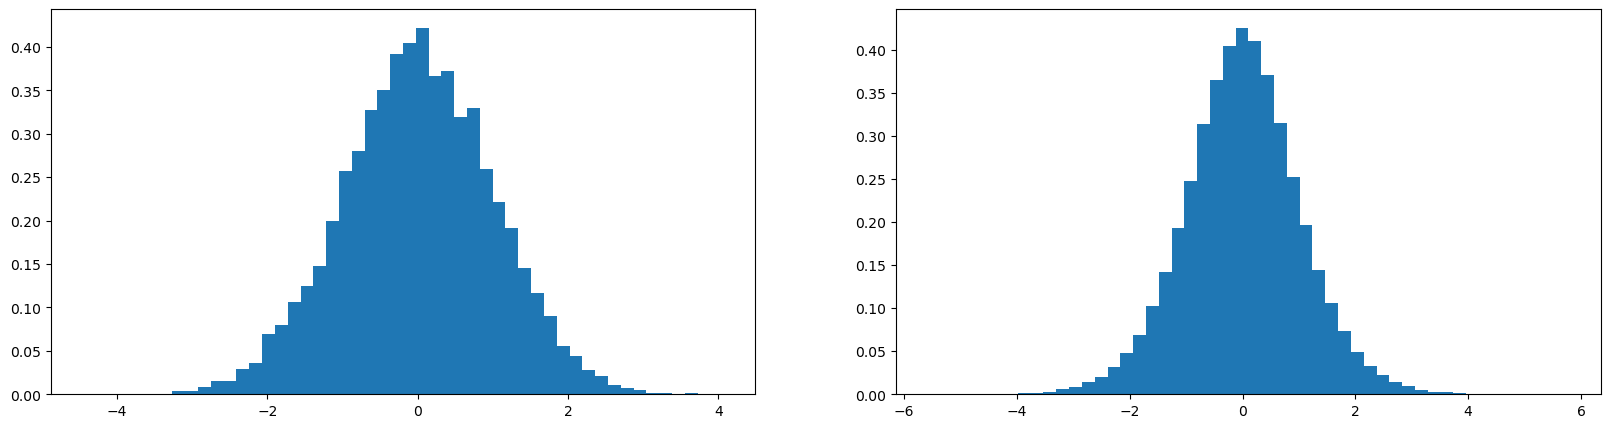

In [66]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / (10 ** 0.5)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);


In [110]:
# same optimization as l2
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # concatenate vectors
    # batch norm
    hpreact = embcat @ W1 # + b1 not needed
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.3147
  10000/ 200000: 2.1341
  20000/ 200000: 2.3173
  30000/ 200000: 2.4115
  40000/ 200000: 2.0124
  50000/ 200000: 2.3003
  60000/ 200000: 2.4708
  70000/ 200000: 2.1208
  80000/ 200000: 2.3562
  90000/ 200000: 2.1095
 100000/ 200000: 1.9329
 110000/ 200000: 2.3919
 120000/ 200000: 1.9794
 130000/ 200000: 2.4764
 140000/ 200000: 2.3703
 150000/ 200000: 2.3098
 160000/ 200000: 2.0003
 170000/ 200000: 1.8345
 180000/ 200000: 2.0355
 190000/ 200000: 1.8853


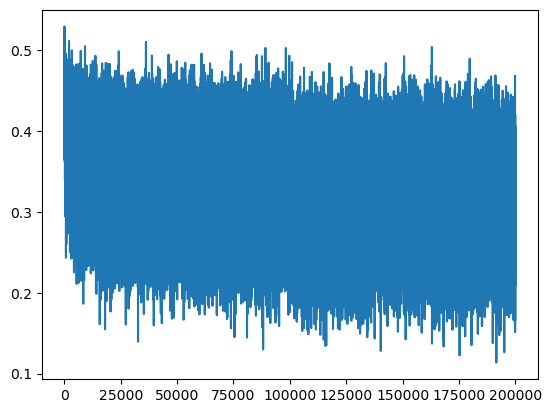

In [111]:
plt.plot(lossi)

In [99]:
# calibrate batchnorm at end of training
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [112]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # not needed + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.061837911605835
val 2.1024703979492188


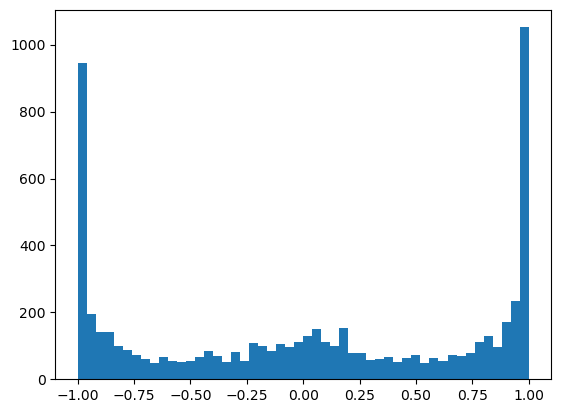

In [63]:
plt.hist(h.view(-1).tolist(), 50);

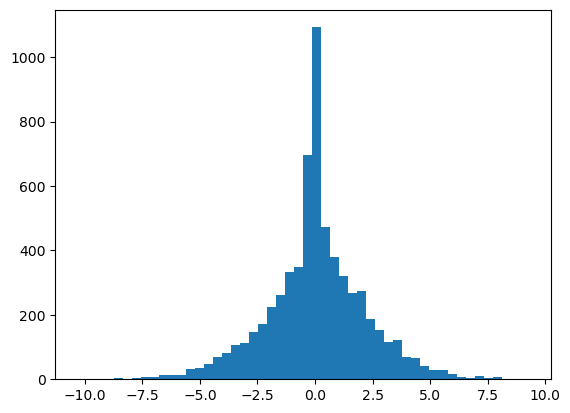

In [64]:
plt.hist(hpreact.view(-1).tolist(), 50);

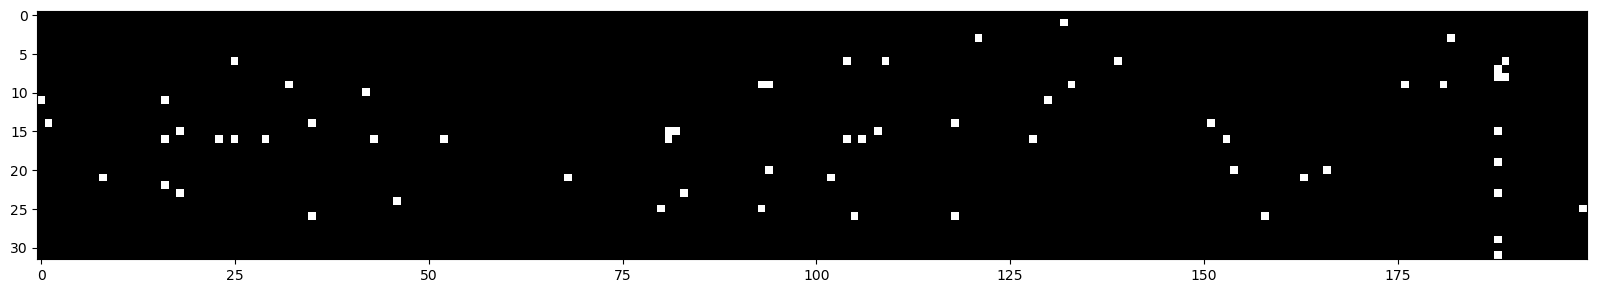

In [59]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [23]:
# sample from model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        h = torch.tanh(embcat @ W1 + b1)
        logits = h @ W2 + b2 # output layer
        probs = F.softmax(logits, dim=1)
        # sample from distro
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift context
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carlah.
amelle.
khi.
mili.
taty.
skanden.
jazhuel.
den.
art.
kaeli.
nellara.
chaiir.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
wazthoniearysi.
jaxeusinsleen.


In [38]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [39]:
# 4-d example
logits = torch.tensor([0., 0., 0., 0.])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))